In [1]:
import pandas as pd
import numpy as np
from readFile import split_into_values, toRPdata
# columns 와 value는 사용자 입력
df = pd.read_csv('resources/AXISX_resample.csv')
# df = pd.read_csv('resources/CLAMP_resample.csv')
value = ['value']
#df = pd.read_csv('resources/Dataset1.csv')
#columns = ['Process', 'Step']
#value = ['Value']

df = df.loc[:, columns + value] #('chip', 'wire', 'value')는 사용자 입력
size = 96
result = split_into_values(df, columns)

# dataframe -> list
result_list = result.values.tolist()

from sklearn.preprocessing import MinMaxScaler

def MinMax(data):
    MMS = MinMaxScaler().fit(data)
    scaled = MMS.transform(data)
    return scaled

# result_list transpose
result_T = [list(x) for x in zip(*result_list)]

# minmax 정규화
result_scaled = MinMax(result_T)

# 다시 result transpose 해서 원래대로
result_scaled = [list(x) for x in zip(*result_scaled)]

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

# 2. 시계열 셋 크기 변경
result_ = TimeSeriesResampler(sz=size).fit_transform(result)

In [10]:
data = result_.reshape(result_.shape[0], 1, size)
X = toRPdata(data, threshold='point', percentage=30)
# X = toRPdata(data)
    
X_scaled = np.expand_dims(X, axis=3)
X_scaled.shape

(1140, 96, 96, 1)

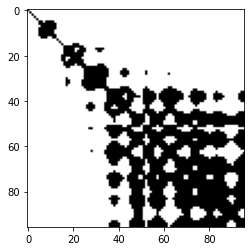

In [12]:
from matplotlib import pyplot as plt
plt.imshow(X[0], cmap='binary')

In [56]:
#you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable

learning_rate = 3e-6
# 3e-4 -> 0.0003
# up -> 0.001, 
# down -> 0.0001, 

optimizer='Adam'
loss='mse'

In [57]:
from utils import split_data, normalization_tool
from agent import Autoencoder_Agent
from utils import optimizer_set
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D

# X_train, X_test, Y_train, Y_test = split_data(X_scaled, X_scaled) #데이터 분리

optimizer = optimizer_set(optimizer, learning_rate)

model = Sequential()

#1st convolution layer
model.add(Conv2D(32, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
, padding='same', input_shape=(96,96,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# #2nd convolution layer
# model.add(Conv2D(32,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#3rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#4rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#here compressed version

#5th convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#6th convolution layer
model.add(Conv2D(16,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#7th convolution layer
model.add(Conv2D(32,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

# #8th convolution layer
# model.add(Conv2D(64,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
# model.add(Activation('relu'))
# model.add(UpSampling2D((2, 2)))


model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))
model.summary()

#학습(약 7000번 정도 진행)
model.compile(optimizer=optimizer, loss=loss) #사용자 지정 파라미터(optimizer, loss)

# metrics 에서 accuracy 는 본래 회귀문제에서(연속적인 값을 예측하는 문제) 사용되는 metric은 아니다. (분류 문제에서 사용됨)
# Keras 는 이를 Binary Accuracy 개념으로 바꾸어, 실제 값과 예측값의 차이값에서 동일한 값을 가지는 것과 틀린것의 비율을 구한다고 볼 수 있다.
# 따라서, RP의 값이 1, 0으로 나누어진 흑백에서는 잘 통할 수 있으나(Binary_accuracy)
# RP값이 연속적일 경우에는 다른 metrics을 알아보아야 한다.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_14 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 48, 48, 16)        4624      
_________________________________________________________________
activation_15 (Activation)   (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 2)        

In [58]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,  min_delta=0.0001)
mc = ModelCheckpoint(f'CLAMP96_Autoencoder_{batch_size}_{learning_rate}_weight.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [82]:
batch_size = 128
epochs = 1000
new_hist = model.fit(X_train, X_train,
          batch_size = batch_size,
          epochs=epochs,
          validation_data=(X_test,X_test),
#           callbacks=[es, mc]
         )

Epoch 1/1000
7/7 [==============================] - 1s 74ms/step - loss: 0.1204 - val_loss: 0.1232
Epoch 2/1000
7/7 [==============================] - 0s 71ms/step - loss: 0.1204 - val_loss: 0.1232
Epoch 3/1000
7/7 [==============================] - 1s 75ms/step - loss: 0.1204 - val_loss: 0.1232
Epoch 4/1000
7/7 [==============================] - 0s 71ms/step - loss: 0.1204 - val_loss: 0.1232
Epoch 5/1000
7/7 [==============================] - 1s 74ms/step - loss: 0.1204 - val_loss: 0.1232
Epoch 6/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1203 - val_loss: 0.1232
Epoch 7/1000
7/7 [==============================] - 1s 79ms/step - loss: 0.1203 - val_loss: 0.1232
Epoch 8/1000
7/7 [==============================] - 1s 81ms/step - loss: 0.1203 - val_loss: 0.1232
Epoch 9/1000
7/7 [==============================] - 1s 80ms/step - loss: 0.1203 - val_loss: 0.1232
Epoch 10/1000
7/7 [==============================] - 1s 77ms/step - loss: 0.1203 - val_loss: 0.1232
Epoch 11/

7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 84/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 85/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 86/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 87/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 88/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 89/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 90/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 91/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 92/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1197 - val_loss: 0.1226
Epoch 93/1000


7/7 [==============================] - 1s 72ms/step - loss: 0.1186 - val_loss: 0.1215
Epoch 246/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1186 - val_loss: 0.1215
Epoch 247/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1186 - val_loss: 0.1215
Epoch 248/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1186 - val_loss: 0.1215
Epoch 249/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1185 - val_loss: 0.1215
Epoch 250/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1185 - val_loss: 0.1215
Epoch 251/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1185 - val_loss: 0.1215
Epoch 252/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1185 - val_loss: 0.1215
Epoch 253/1000
7/7 [==============================] - 1s 74ms/step - loss: 0.1185 - val_loss: 0.1215
Epoch 254/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1185 - val_loss: 0.1215
Epoch

7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1206
Epoch 408/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1206
Epoch 409/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1206
Epoch 410/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1206
Epoch 411/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1206
Epoch 412/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1176 - val_loss: 0.1206
Epoch 413/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1206
Epoch 414/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1176 - val_loss: 0.1205
Epoch 415/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1205
Epoch 416/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1176 - val_loss: 0.1205
Epoch

7/7 [==============================] - 1s 72ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 570/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 571/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 572/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 573/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 574/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 575/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 576/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 577/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch 578/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1168 - val_loss: 0.1198
Epoch

7/7 [==============================] - 1s 72ms/step - loss: 0.1162 - val_loss: 0.1192
Epoch 732/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 733/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 734/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 735/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 736/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 737/1000
7/7 [==============================] - 0s 71ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 738/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 739/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch 740/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1161 - val_loss: 0.1192
Epoch

7/7 [==============================] - 1s 73ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 894/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 895/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 896/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 897/1000
7/7 [==============================] - 1s 73ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 898/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 899/1000
7/7 [==============================] - 1s 74ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 900/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 901/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch 902/1000
7/7 [==============================] - 1s 72ms/step - loss: 0.1156 - val_loss: 0.1186
Epoch

In [83]:
import pickle
hist = {}
try: 
    prev_hist = pickle.load(open(f'CLAMP96_Autoencoder_{batch_size}_{learning_rate}history', "rb"))
except:
    hist = new_hist.history
else:
    for key in prev_hist.keys():
        hist[key] = prev_hist[key] + new_hist.history[key]
hist
with open(f'CLAMP96_Autoencoder_{batch_size}_{learning_rate}history', 'wb') as file_pi:
        pickle.dump(hist, file_pi)

In [84]:
len(hist['loss'])

3500

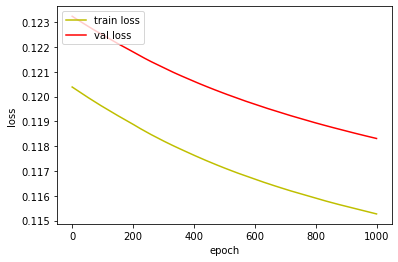

In [85]:
plt.plot(new_hist.history['loss'], 'y', label='train loss')
plt.plot(new_hist.history['val_loss'], 'r', label='val loss')
# loss_ax.plot([hist['loss'][i] - hist['val_loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')


plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc='upper left')

plt.show()

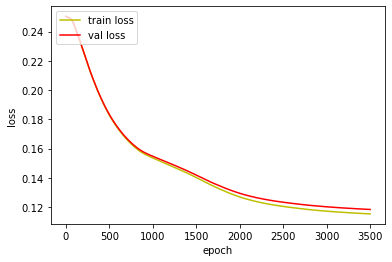

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(hist['loss'], 'y', label='train loss')
loss_ax.plot(hist['val_loss'], 'r', label='val loss')
# loss_ax.plot([hist['loss'][i] - hist['val_loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

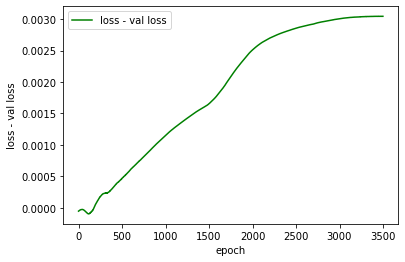

In [87]:
plt.plot([hist['val_loss'][i] - hist['loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')
plt.xlabel('epoch')
plt.ylabel('loss - val loss')
plt.legend(loc='upper left')
plt.show()

In [97]:
y_pred = model.predict(X_test)
# print(y_pred[0])
# print(X_test.shape)
# print(((np.round(y_pred[0]) == X_test[0]) + (np.round(y_pred[1]) == X_test[1]))/ 2)
l = len(X_test)
acc = sum([np.round(y_pred[i])==X_test[i] for i in range(l)])/l
# acc = sum([y_pred[i]==X_test[i] for i in range(l)])/l
np.mean(acc)

0.010417318360026693

In [90]:
y_pred[0]
X_test[0]

array([[[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]])

In [72]:
lst1 = np.array([[[[1],[2]], [[1],[2]]], [[[1],[2]], [[1],[2]]]])
lst2 = np.array([[[[1],[2]], [[1],[4]]], [[[1],[4]], [[1],[2]]]])

print(sum([lst1[i] == lst2[i] for i in range(2)]))
#

[[[2]
  [1]]

 [[2]
  [1]]]


In [32]:
from keras import backend as K
get_layer_output = K.function([model.layers[0].input],[model.layers[8].output])
compressed = get_layer_output([X_train])[0]
feature = compressed.reshape(compressed.shape[0], compressed.shape[1]*compressed.shape[2]*compressed.shape[3])
print(feature)
print(feature.shape)

[[0.         0.7288813  0.         ... 0.19060244 0.01965969 0.27075973]
 [0.27627707 0.23691434 0.12823673 ... 0.4054701  0.13754071 0.16189253]
 [0.1528883  0.5069024  0.         ... 0.17404582 0.00574959 0.20704743]
 ...
 [0.01133747 0.60169214 0.         ... 0.12990808 0.15640005 0.11846576]
 [0.         0.72082096 0.         ... 0.33408728 0.         0.40843672]
 [0.36388862 0.22455132 0.03131079 ... 0.5912214  0.08734117 0.01690575]]
(997, 288)
